# Sto learning 


In [14]:
import sys
sys.path.insert(0, "../lib/")
import ninja
import laplacian
import utils
import model
import graphs
from laplacian import normalized_laplacian
from utils import set_device
import os
import sys
import time

# -------------Torch--------------------------
import torch
from torch.utils.data import DataLoader

# -------------Graph--------------------------
import dgl
import matplotlib.pyplot as plt

# Autoreload
%load_ext autoreload
%autoreload 2

# GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = set_device(verbose=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda available


# MNIST

In [2]:
# Downloads the dataset if not found locally
from dataset import check_mnist_dataset_exists, datasampler, MNIST_rand, MNISTDataset

_ = check_mnist_dataset_exists()

nb_selected_train_data = 60000
nb_selected_test_data = 1024

train_data, train_labels, test_data, test_labels = datasampler(
    nb_selected_train_data, nb_selected_test_data
)

In [3]:
trainset = MNIST_rand(train_data, train_labels, removal_rate=0.25)
testset = MNIST_rand(test_data, test_labels, removal_rate=0.25)



# Model definition for training

In [4]:
from model import Classifier
# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 10
n_classes = trainset.num_classes

net = Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
)

print(net)
if torch.cuda.is_available():
    net.to(device)

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=10, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=320, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
from utils import load_model
net.load_state_dict(load_model('Model_sto_25pcedges_6000_25ep'))

<All keys matched successfully>

# Training pipe

In [6]:
import torch.optim as optim
import torch.nn as nn
#
from utils import collate
#

data_loader = DataLoader(trainset, batch_size=1000,
                         shuffle=True, collate_fn=collate)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr= 0.002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95)

epoch_losses = []

## Training time

In [ ]:
from laplacian import normalized_laplacian

net.train()
#optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in range(2):
    epoch_loss = 0
    t0 = time.time()
    for iter, (bg, label, signal) in enumerate(data_loader):
        L = normalized_laplacian(bg)

        prediction = net(bg.to(device), signal.to(device), L.to(device))

        if iter == 0:
            t = time.time()
            print("One Prediction:\n", prediction[0], 'len:',
                  prediction.size(), '\n label:', label[0])  # DEBUG

        loss = loss_func(prediction, label.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.detach().item()

    epoch_loss /= iter + 1
    
    scheduler.step()
    
    print(
        "Epoch {}, loss {:.4f}, in {:.2f}(s) ".format(
            epoch, epoch_loss, time.time() - t0
        )
    )
    epoch_losses.append(epoch_loss)

/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


One Prediction:
 tensor([  2.9558,  -2.4807,   0.2050,  -3.2764,  -7.0152,   6.4659,   8.0200,
        -14.8377,   4.3009,  -4.8221], device='cuda:0',
       grad_fn=<SelectBackward>) len: torch.Size([1000, 10]) 
 label: tensor(6)


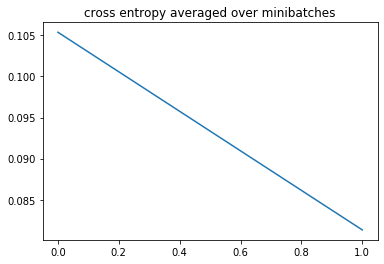

In [15]:
plt.title("cross entropy averaged over minibatches")
plt.plot(epoch_losses)
plt.show()

In [16]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.002
    lr: 0.0019
    weight_decay: 0
)

In [20]:
torch.cuda.empty_cache()

## Test Metrics

In [17]:
# Change

net.eval()
# Convert a list of tuples to two lists
test_X, test_Y, test_S = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
L = normalized_laplacian(test_bg)
test_S = torch.stack(test_S).view(-1)
probs_Y = torch.softmax(net(test_bg.to(device),test_S.to(device), L.to(device)), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print(
    "Accuracy of sampled predictions on the test set: {:.4f}%".format(
        (test_Y == sampled_Y.cpu().float()).sum().item() / len(test_Y) * 100
    )
)
print(
    "Accuracy of argmax predictions on the test set: {:4f}%".format(
        (test_Y == argmax_Y.cpu().float()).sum().item() / len(test_Y) * 100
    )
)

/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


Accuracy of sampled predictions on the test set: 96.8750%
Accuracy of argmax predictions on the test set: 98.046875%


In [18]:
# BATCHED DGL EXAMPLE
import sklearn
from sklearn.metrics import classification_report

print(sklearn.metrics.classification_report(test_Y.cpu(), argmax_Y.cpu()))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        87
         1.0       1.00      0.98      0.99       130
         2.0       0.95      0.99      0.97       118
         3.0       0.97      0.98      0.98       108
         4.0       0.98      0.98      0.98       113
         5.0       0.99      0.97      0.98        89
         6.0       1.00      0.97      0.98        89
         7.0       0.98      1.00      0.99       102
         8.0       0.97      0.95      0.96        91
         9.0       0.99      0.98      0.98        97

    accuracy                           0.98      1024
   macro avg       0.98      0.98      0.98      1024
weighted avg       0.98      0.98      0.98      1024



## Saving

In [21]:
from utils import save_model

save_model("Model_sto", net)